# Self-Driving Car Engineer Nanodegree
## Machine Learning
## Project: Vehicle Detection and Tracking
### Vehicle Classifier Training


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler
from random import randint

#### Read in Images Directories

In [3]:
# Read in cars and notcars images and show how many they are.
images = glob.glob('data/non-vehicles/Extras/*.png')
images2 = glob.glob('data/non-vehicles/GTI/*.png')
notcar_images = images+images2
print('# of Non-Vehicles Images: '+np.str(len(notcar_images)))
images = glob.glob('data/vehicles/GTI_Far/*.png')
images2 = glob.glob('data/vehicles/GTI_Left/*.png')
images3 = glob.glob('data/vehicles/GTI_MiddleClose/*.png')
images4 = glob.glob('data/vehicles/GTI_Right/*.png')
images5 = glob.glob('data/vehicles/KITTI_extracted/*.png')
car_images = images+images2+images3+images4+images5
print('# of Vehicles Images: '+np.str(len(car_images)))


# of Non-Vehicles Images: 8968
# of Vehicles Images: 8792


#### Show Random Samples in Non-Vehicles and Vehicles Images

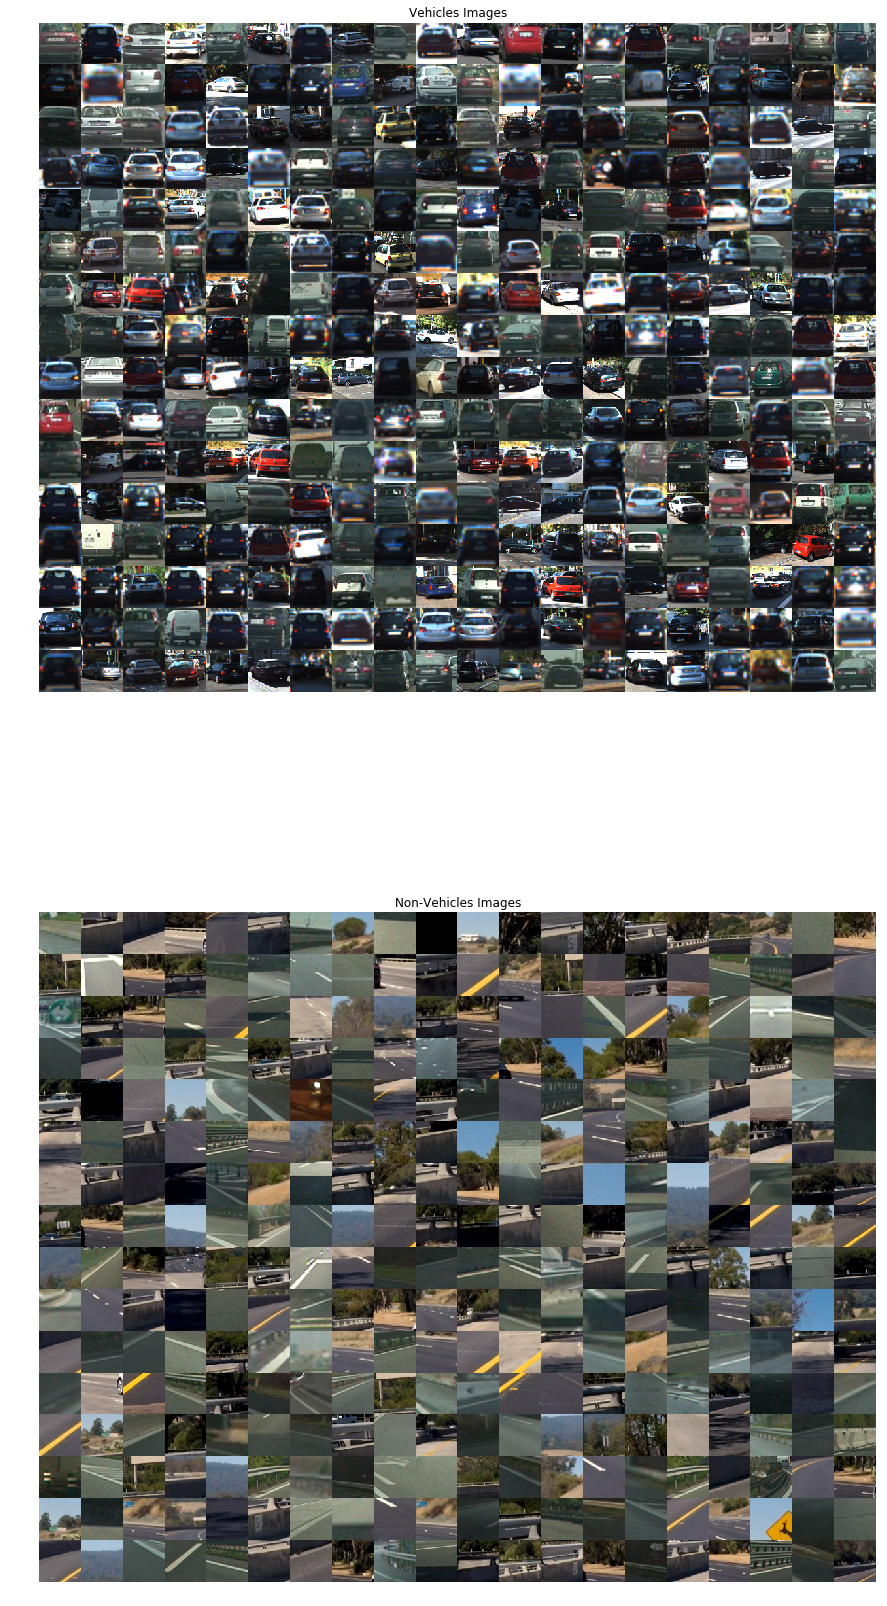

In [4]:
# show images
def show_images(INPUT):
    random = [randint(0,len(INPUT)) for i in range(0,20)]
    OUTPUT = np.concatenate([cv2.imread(INPUT[ind]) for ind in random], axis=1)
    for i in range(0,15):
        random = [randint(0,len(INPUT)) for i in range(0,20)]
        OUTPUT = np.concatenate((OUTPUT,
                             np.concatenate([cv2.imread(INPUT[ind]) for ind in random], axis=1)
                            ),axis=0)
    return OUTPUT

fig, ax = plt.subplots(2,1,figsize=(15,30))
ax[0].imshow(cv2.cvtColor(show_images(car_images), cv2.COLOR_BGR2RGB))
ax[0].set_title('Vehicles Images')
ax[0].axis('off')
ax[1].imshow(cv2.cvtColor(show_images(notcar_images), cv2.COLOR_BGR2RGB))
ax[1].set_title('Non-Vehicles Images')
ax[1].axis('off')
plt.show()

#### Color Histogram

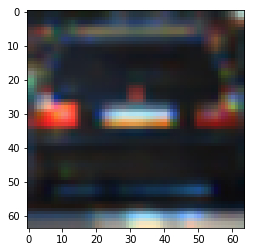

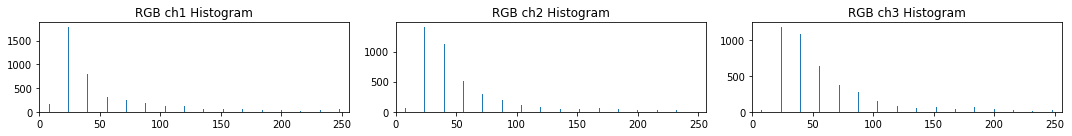

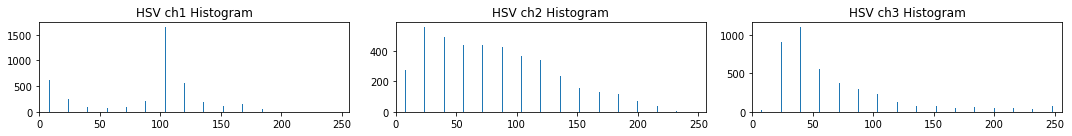

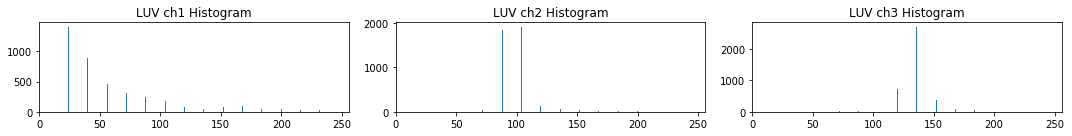

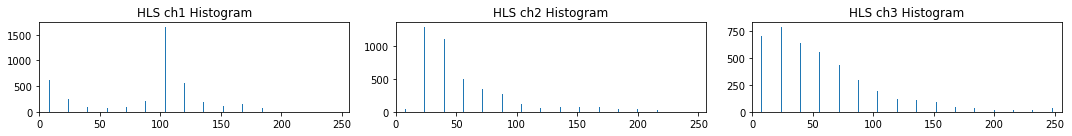

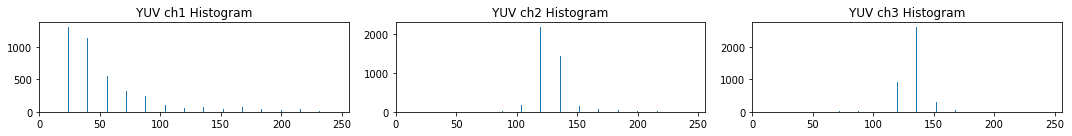

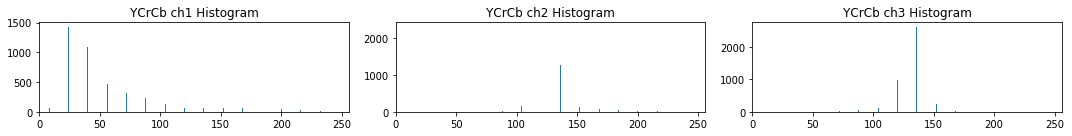

In [27]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    hist1 = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    hist2 = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    hist3 = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = hist1[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((hist1[0], hist2[0], hist3[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist1, hist2, hist3, bin_centers, hist_features

def colot_hist_visualization(bincen,ch1,ch2,ch3,c_type):
    # Plot a figure with all three bar charts
    fig = plt.figure(figsize=(15,2))
    plt.subplot(131)
    plt.bar(bincen, ch1[0])
    plt.xlim(0, 256)
    plt.title(c_type+' ch1 Histogram')
    plt.subplot(132)
    plt.bar(bincen, ch2[0])
    plt.xlim(0, 256)
    plt.title(c_type+' ch2 Histogram')
    plt.subplot(133)
    plt.bar(bincen, ch3[0])
    plt.xlim(0, 256)
    plt.title(c_type+' ch3 Histogram')
    fig.tight_layout()
    plt.show()

ori_image = cv2.imread(car_images[3500])
#ori_image = cv2.imread(car_images[4500])
#ori_image = cv2.imread(notcar_images[1300])
plt.imshow(cv2.cvtColor(ori_image, cv2.COLOR_BGR2RGB))
plt.show()

image = cv2.cvtColor(ori_image, cv2.COLOR_BGR2RGB)
ch1, ch2, ch3, bincen, feature_vec = color_hist(image, nbins=16, bins_range=(0, 256))
colot_hist_visualization(bincen,ch1,ch2,ch3,'RGB')

image = cv2.cvtColor(ori_image, cv2.COLOR_BGR2HSV)
ch1, ch2, ch3, bincen, feature_vec = color_hist(image, nbins=16, bins_range=(0, 256))
colot_hist_visualization(bincen,ch1,ch2,ch3,'HSV')

image = cv2.cvtColor(ori_image, cv2.COLOR_BGR2LUV)
ch1, ch2, ch3, bincen, feature_vec = color_hist(image, nbins=16, bins_range=(0, 256))
colot_hist_visualization(bincen,ch1,ch2,ch3,'LUV')

image = cv2.cvtColor(ori_image, cv2.COLOR_BGR2HLS)
ch1, ch2, ch3, bincen, feature_vec = color_hist(image, nbins=16, bins_range=(0, 256))
colot_hist_visualization(bincen,ch1,ch2,ch3,'HLS')

image = cv2.cvtColor(ori_image, cv2.COLOR_BGR2YUV)
ch1, ch2, ch3, bincen, feature_vec = color_hist(image, nbins=16, bins_range=(0, 256))
colot_hist_visualization(bincen,ch1,ch2,ch3,'YUV')

image = cv2.cvtColor(ori_image, cv2.COLOR_BGR2YCrCb)
ch1, ch2, ch3, bincen, feature_vec = color_hist(image, nbins=16, bins_range=(0, 256))
colot_hist_visualization(bincen,ch1,ch2,ch3,'YCrCb')

#### Color Space 

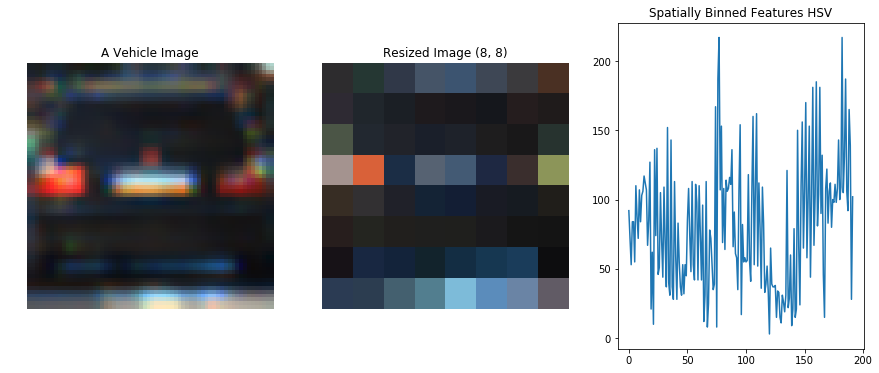

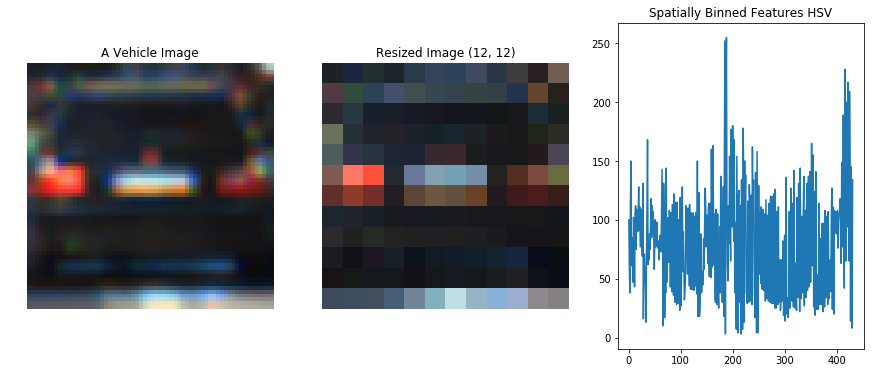

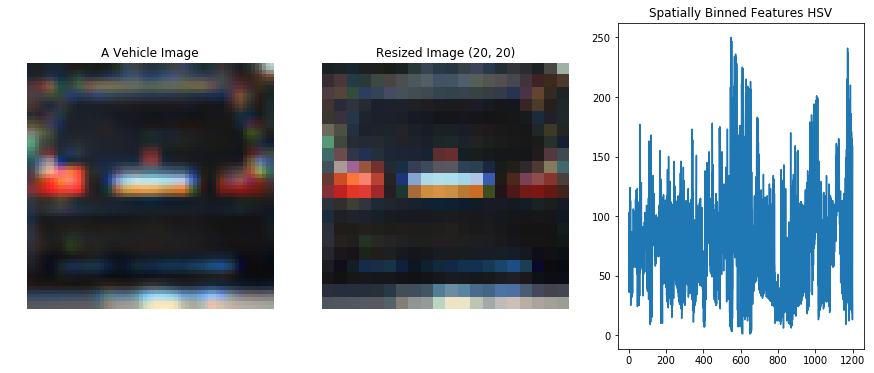

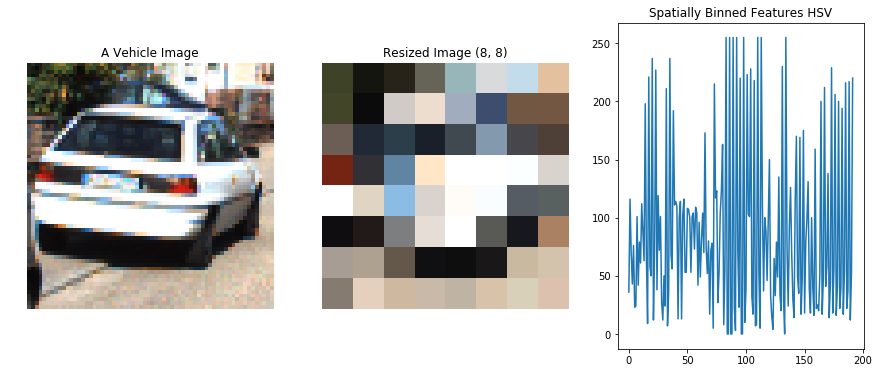

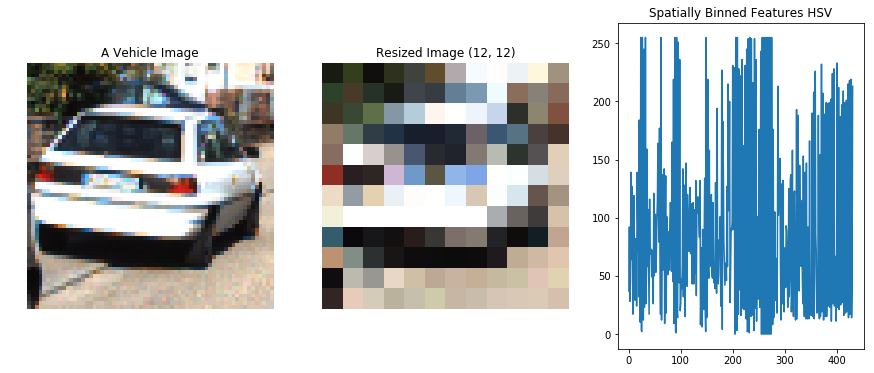

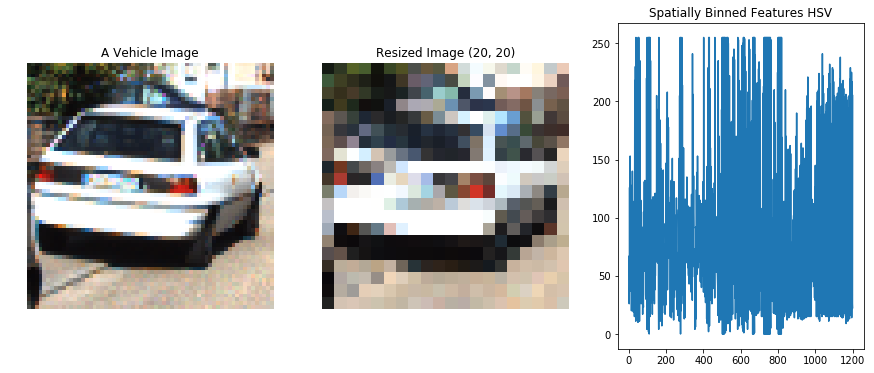

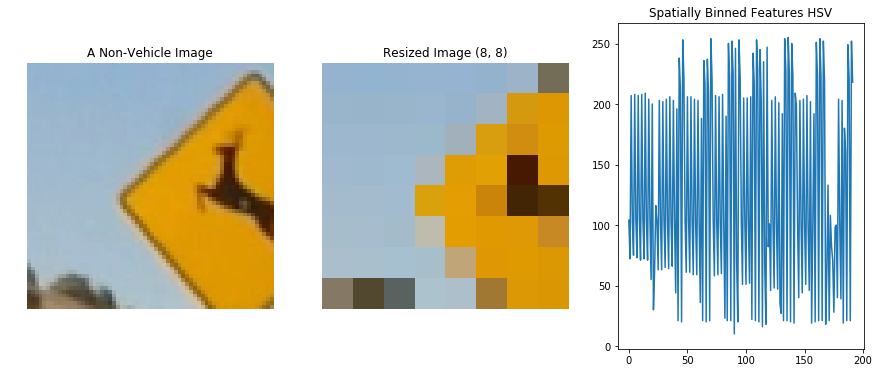

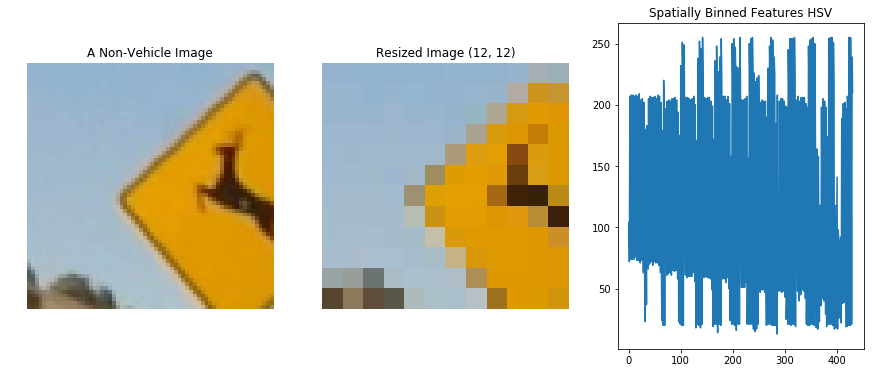

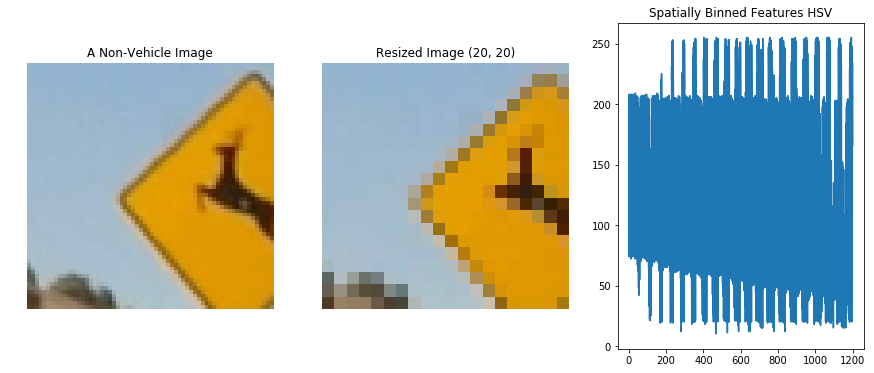

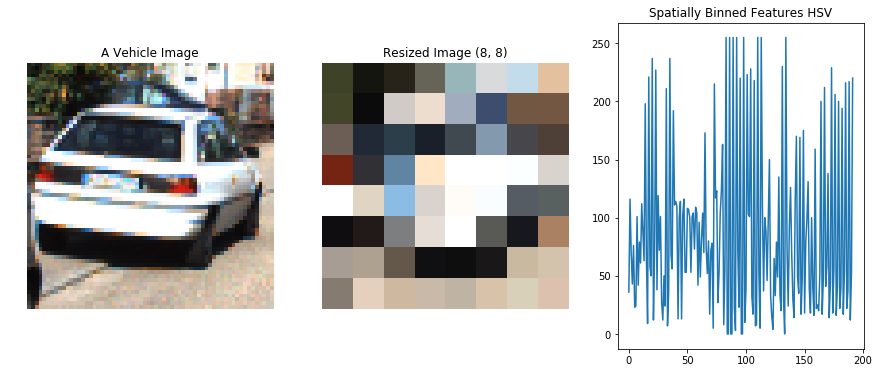

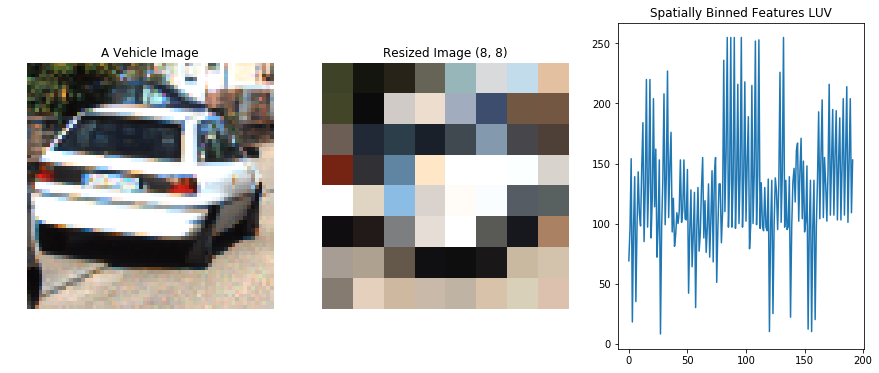

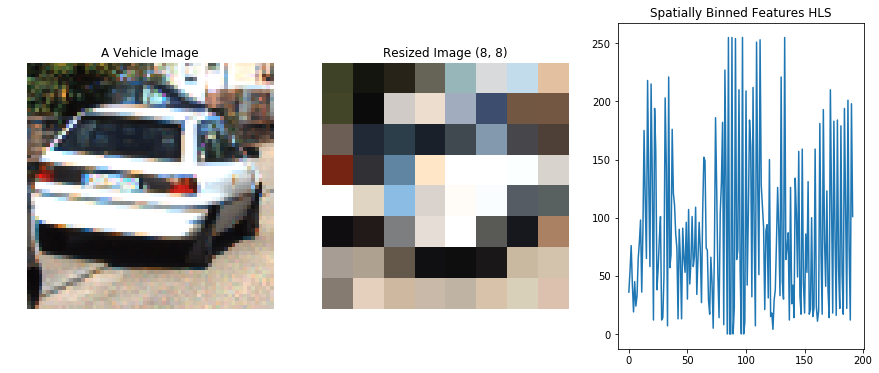

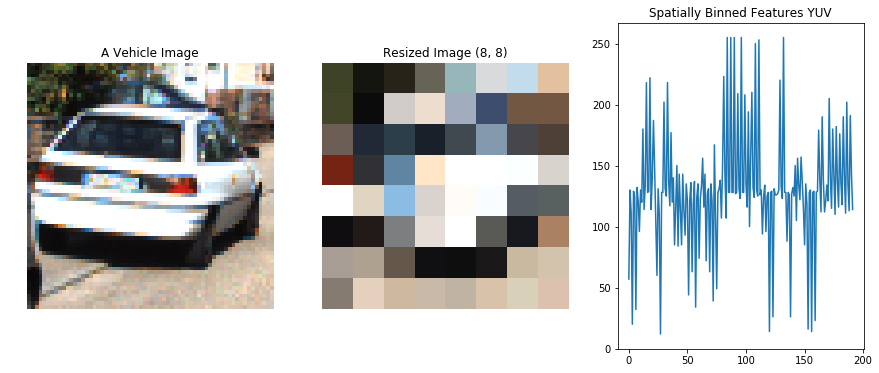

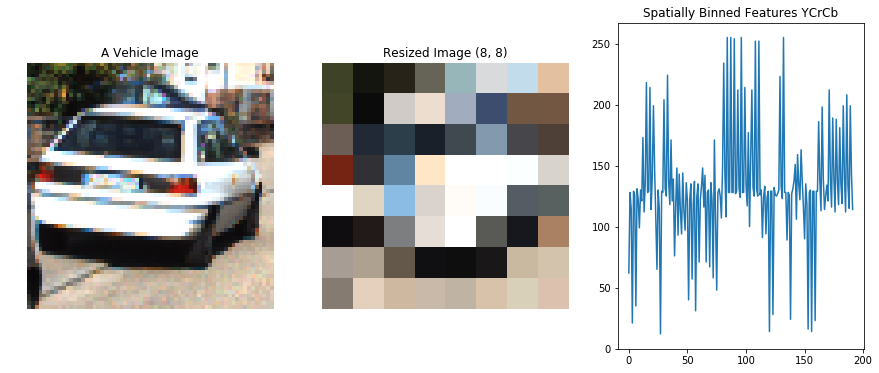

In [22]:
# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
# KEEP IN MIND IF YOU DECIDE TO USE THIS FUNCTION LATER
# IN YOUR PROJECT THAT IF YOU READ THE IMAGE WITH 
# cv2.imread() INSTEAD YOU START WITH BGR COLOR!
def bin_spatial(img, color_space='BGR', size=(32, 32)):
    feature_image=None
    # Convert image to new color space (if specified)
    if color_space != 'BGR':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    else: feature_image = np.copy(img)
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel()
    # Return the feature vector
    return features

def plot_features(image,resize_image,size,feature_vec,im_type,color):
    # Plot features
    fig, ax = plt.subplots(1,3,figsize=(15,6))
    ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[0].set_title(im_type)
    ax[0].axis('off')
    ax[1].imshow(cv2.cvtColor(resize_image, cv2.COLOR_BGR2RGB))
    ax[1].set_title('Resized Image '+np.str(size))
    ax[1].axis('off')
    ax[2].plot(feature_vec)
    ax[2].set_title('Spatially Binned Features '+color)
    plt.show()

def visualize(image,size,color_space,im_type,):
    resize_image = cv2.resize(image,size)
    feature_vec = bin_spatial(image, color_space, size)
    plot_features(image,resize_image,size,feature_vec,im_type,color_space)

    
# For Visualization
image = cv2.imread(car_images[3500])
visualize(image,size=(8,8),color_space='HSV',im_type='A Vehicle Image')
visualize(image,size=(12,12),color_space='HSV',im_type='A Vehicle Image')
visualize(image,size=(20,20),color_space='HSV',im_type='A Vehicle Image')
image = cv2.imread(car_images[4500])
visualize(image,size=(8,8),color_space='HSV',im_type='A Vehicle Image')
visualize(image,size=(12,12),color_space='HSV',im_type='A Vehicle Image')
visualize(image,size=(20,20),color_space='HSV',im_type='A Vehicle Image')
image = cv2.imread(notcar_images[1300])
visualize(image,size=(8,8),color_space='HSV',im_type='A Non-Vehicle Image')
visualize(image,size=(12,12),color_space='HSV',im_type='A Non-Vehicle Image')
visualize(image,size=(20,20),color_space='HSV',im_type='A Non-Vehicle Image')

# Read in an image
image = cv2.imread(car_images[4500])
visualize(image,size=(8,8),color_space='HSV',im_type='A Vehicle Image')
visualize(image,size=(8,8),color_space='LUV',im_type='A Vehicle Image')
visualize(image,size=(8,8),color_space='HLS',im_type='A Vehicle Image')
visualize(image,size=(8,8),color_space='YUV',im_type='A Vehicle Image')
visualize(image,size=(8,8),color_space='YCrCb',im_type='A Vehicle Image')


#### HOG 

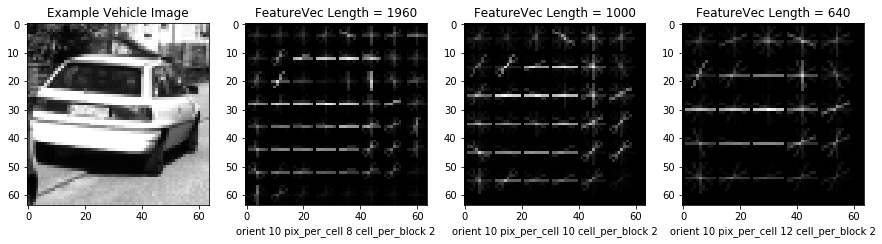

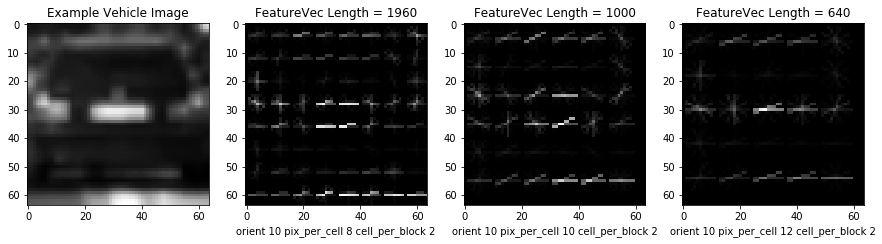

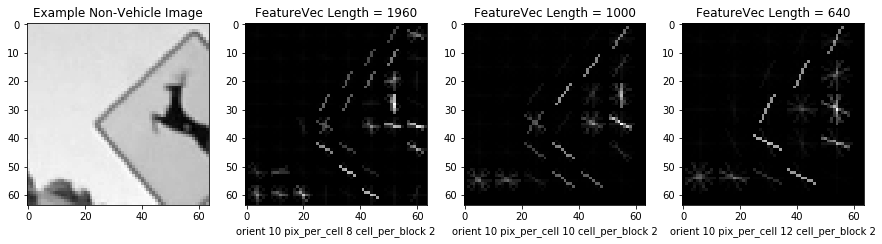

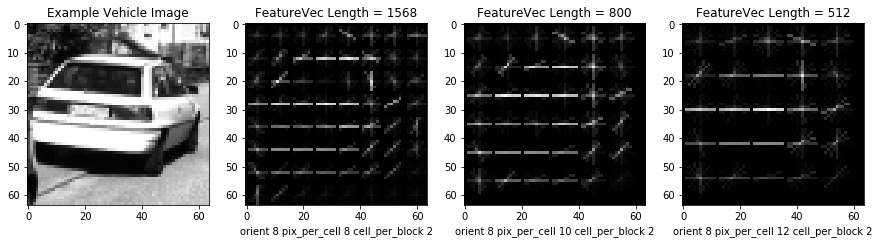

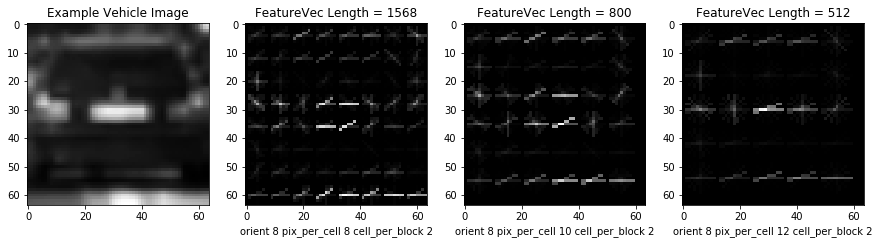

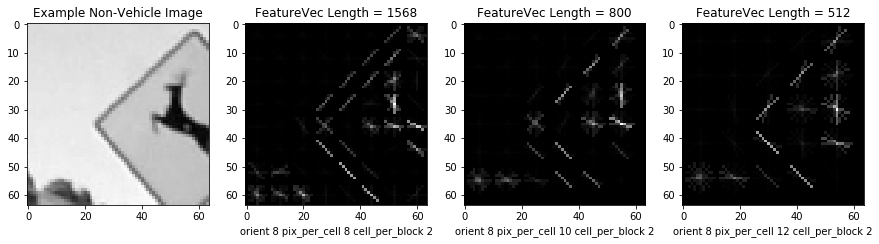

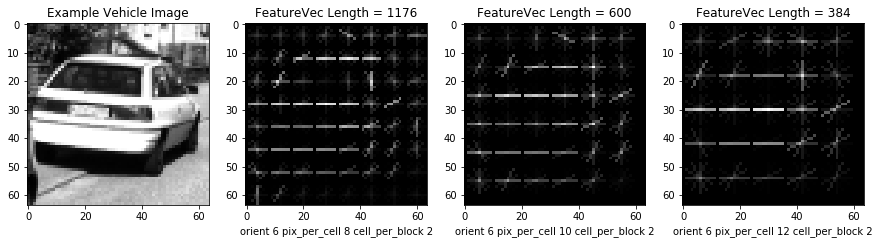

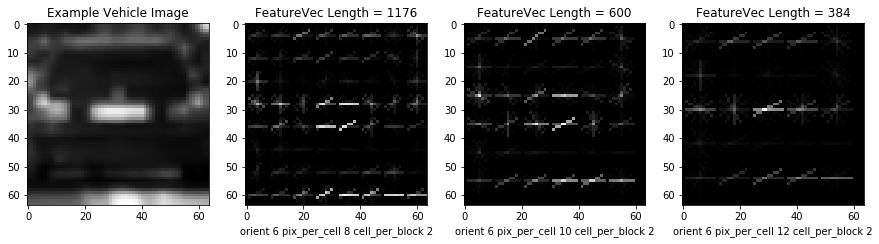

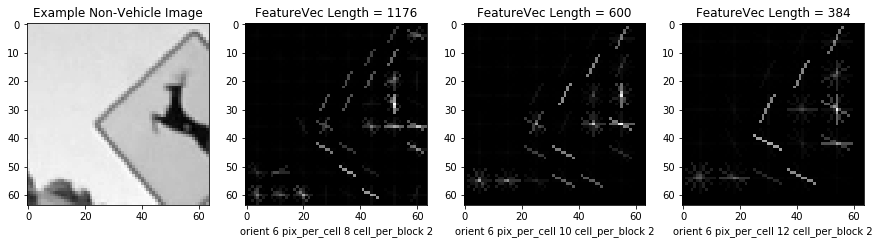

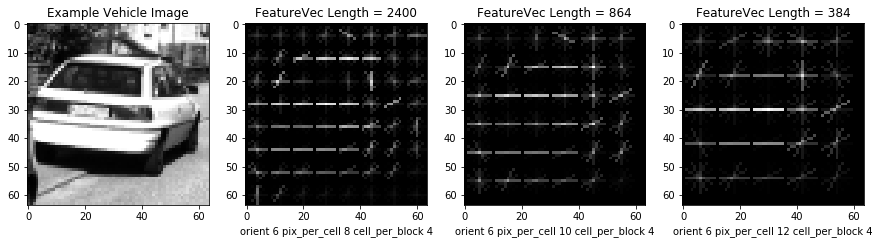

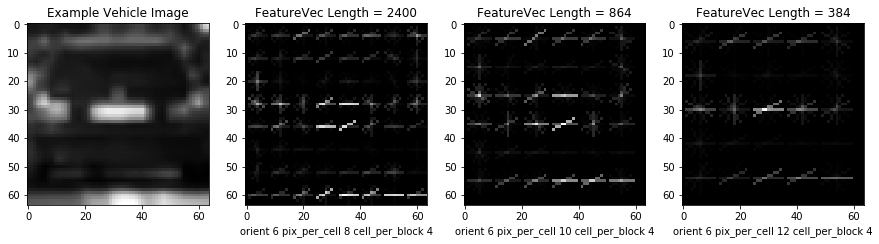

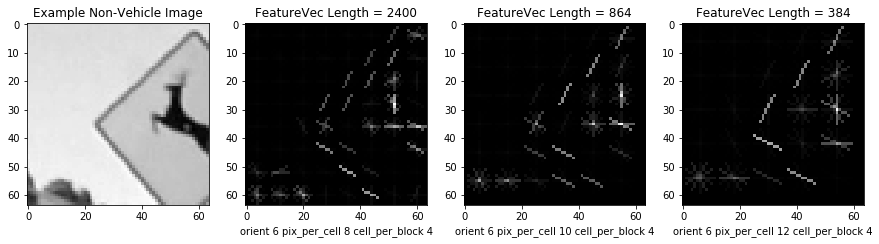

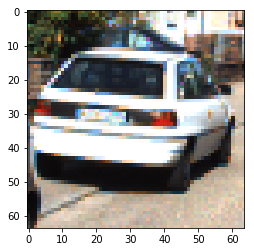

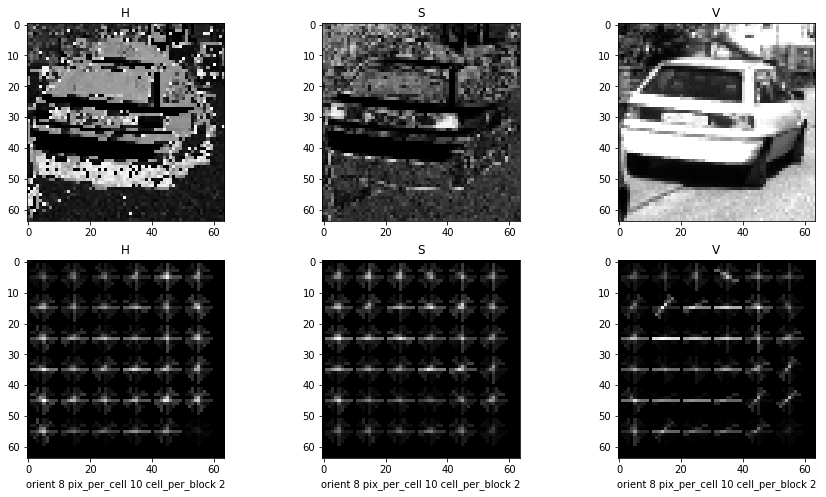

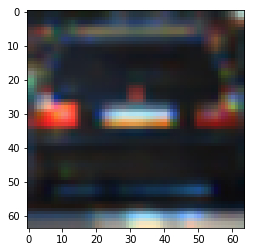

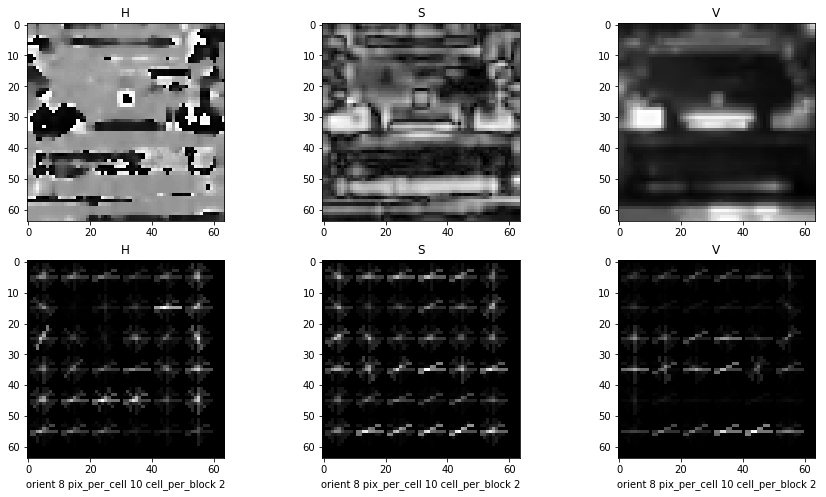

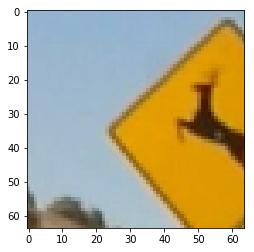

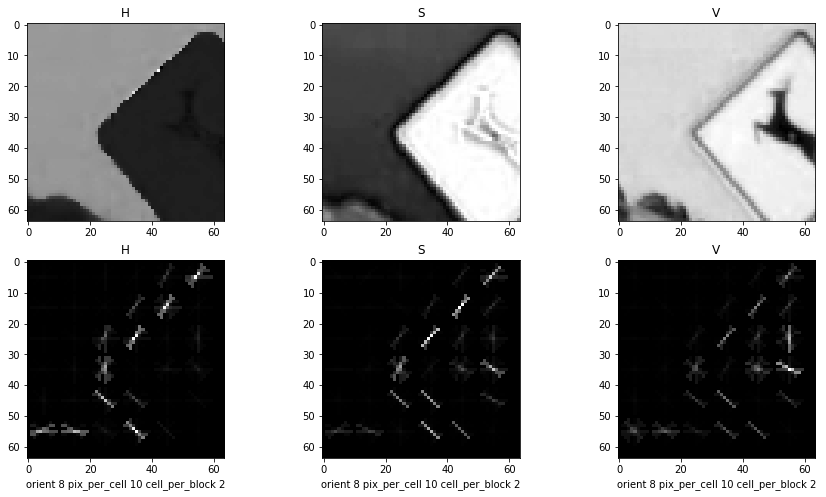

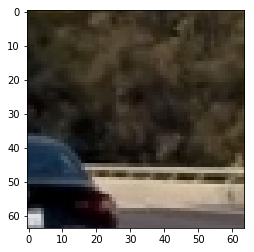

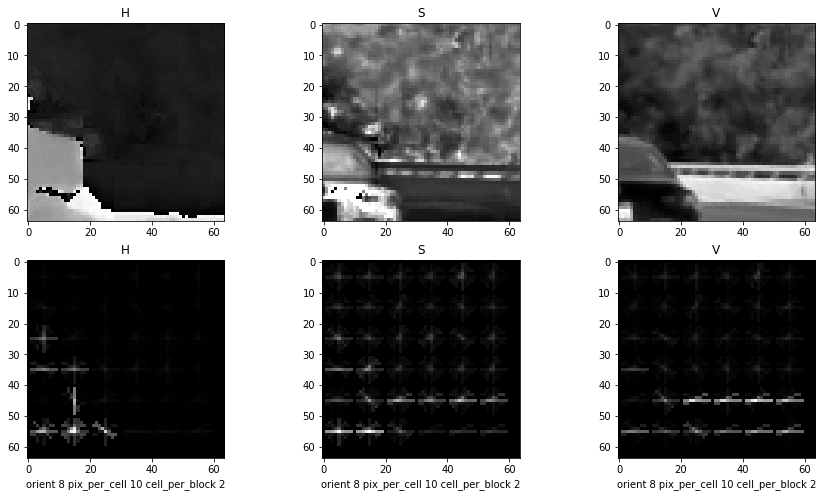

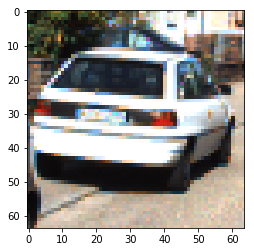

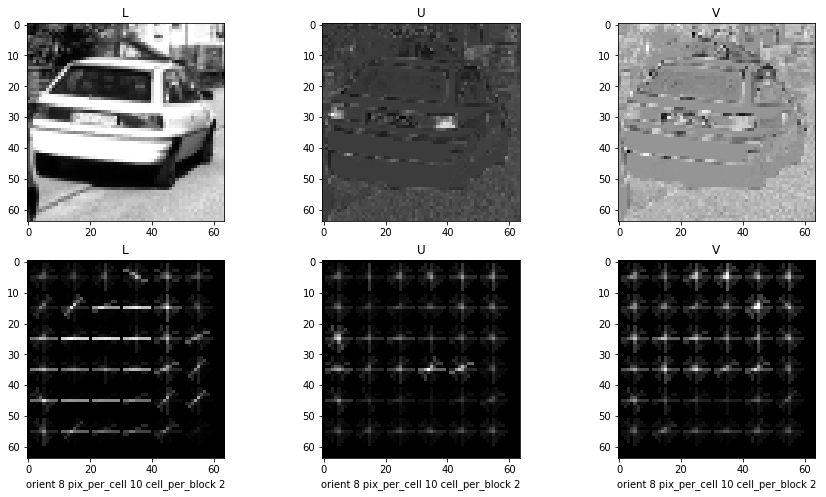

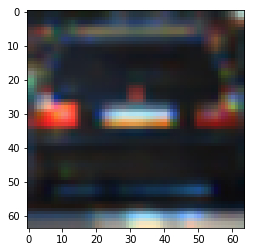

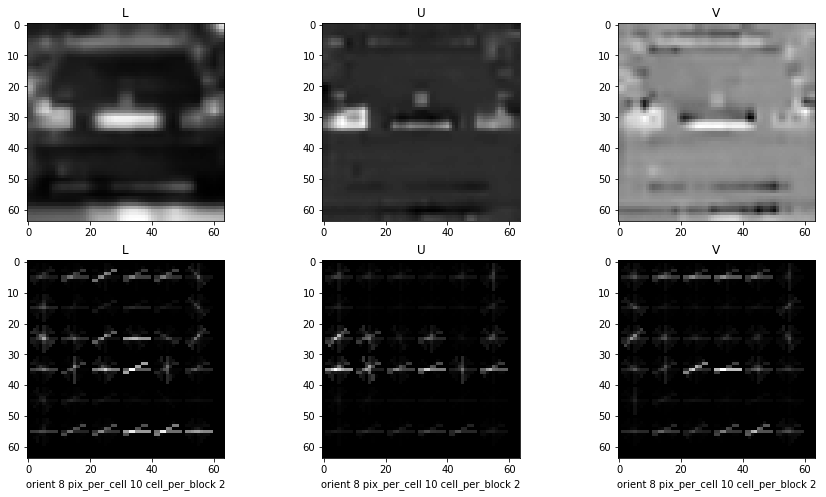

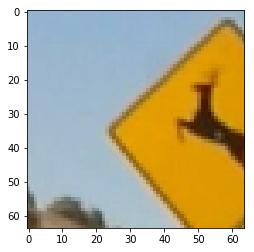

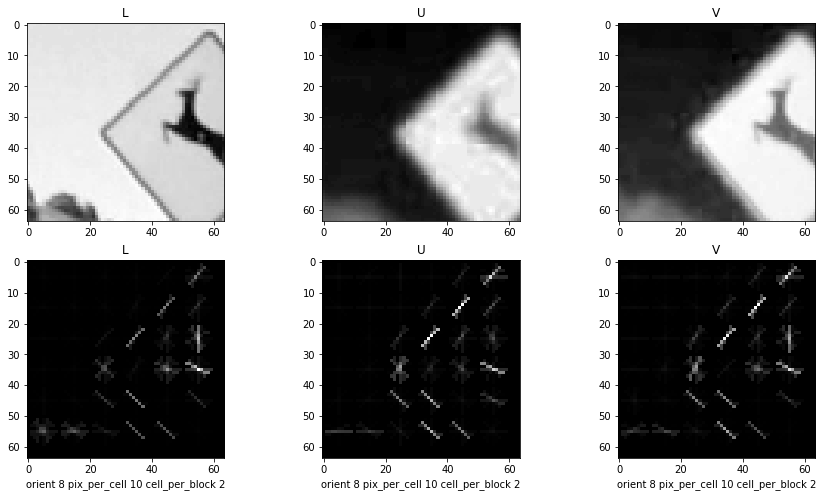

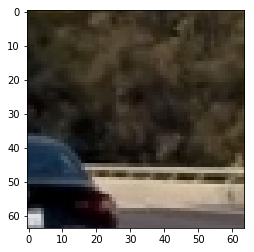

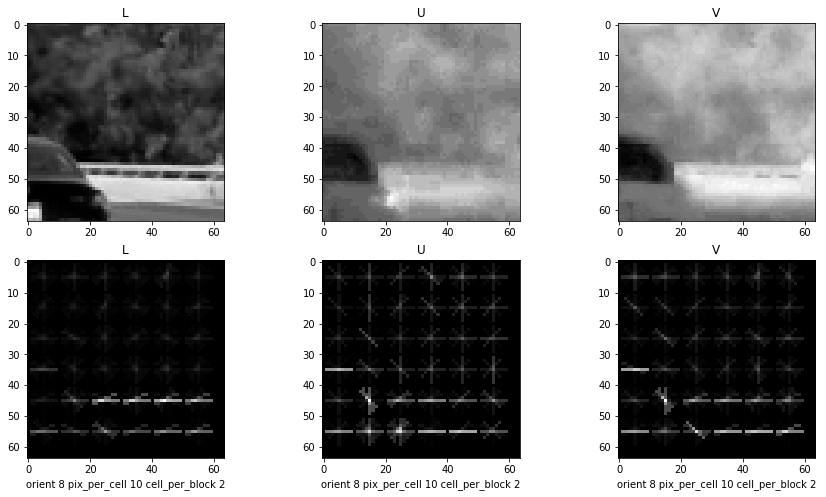

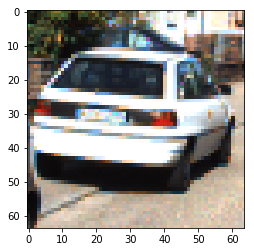

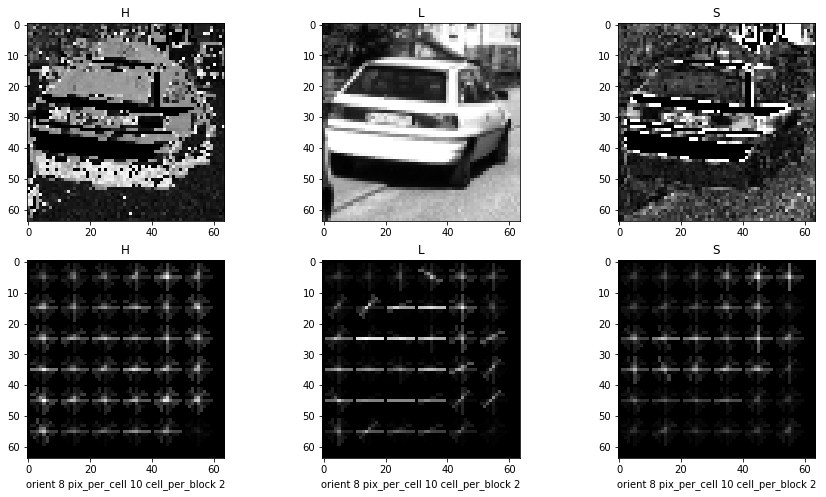

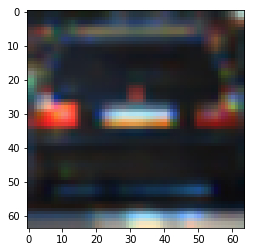

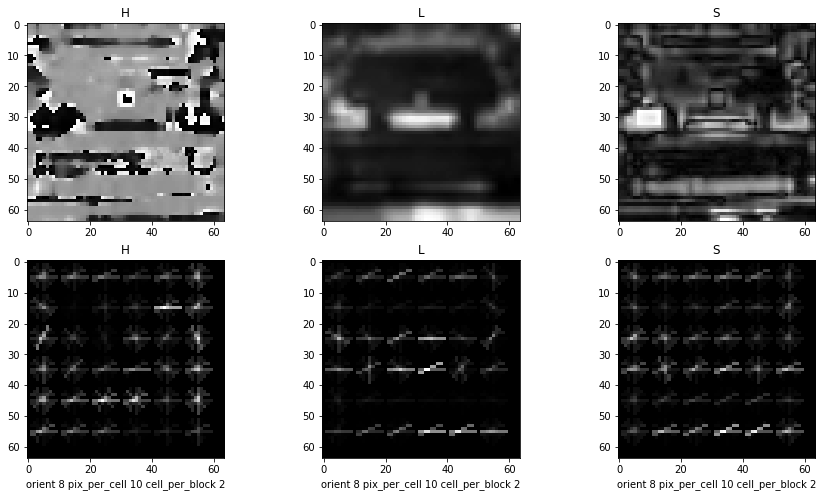

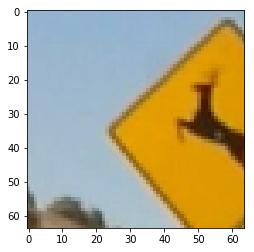

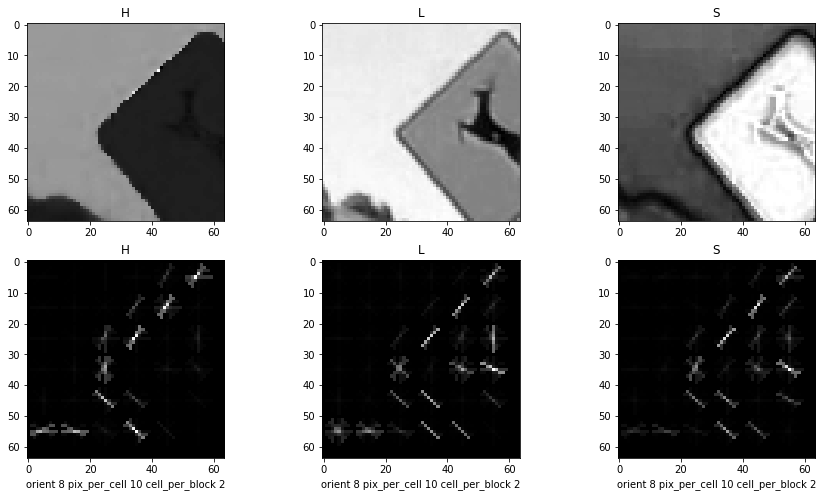

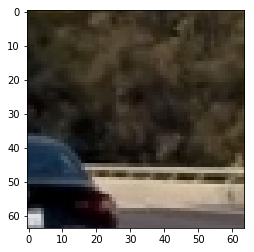

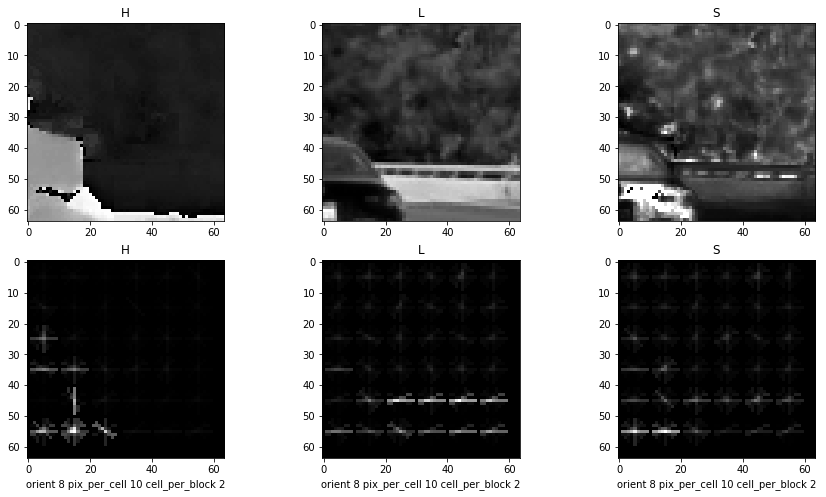

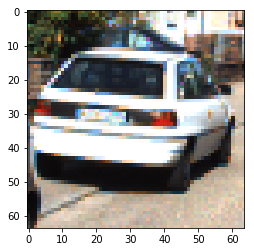

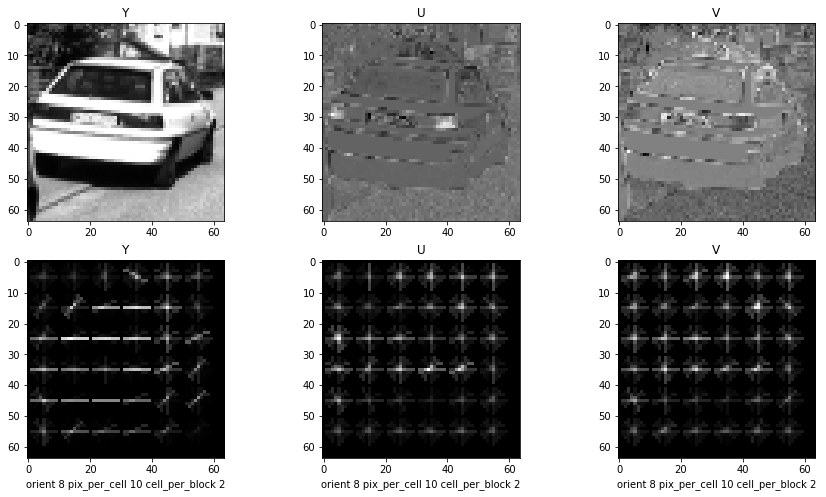

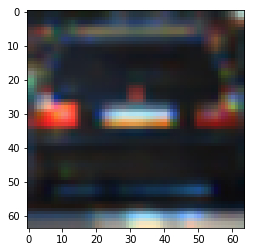

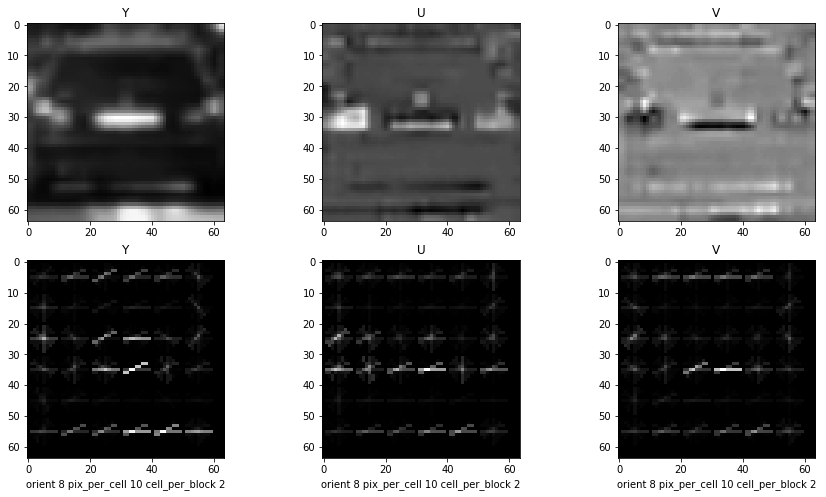

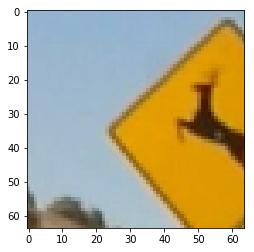

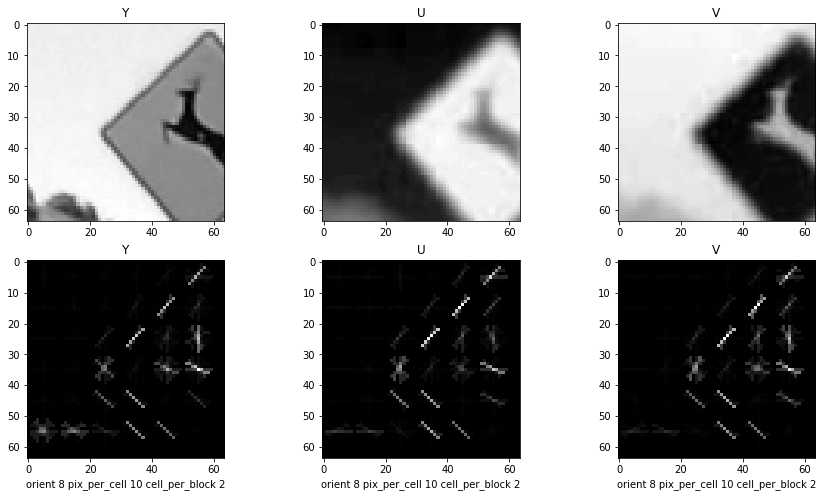

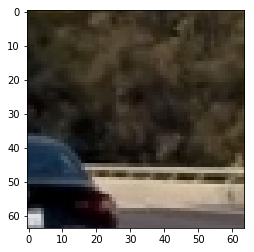

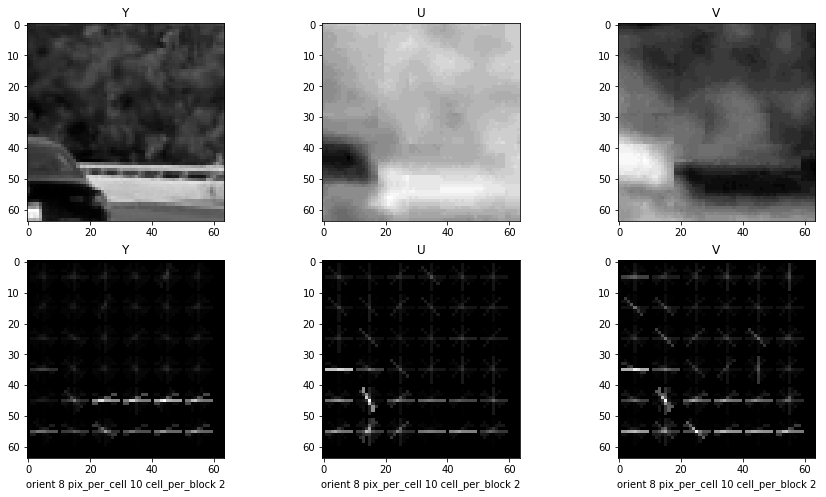

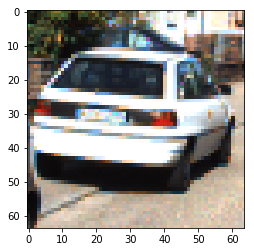

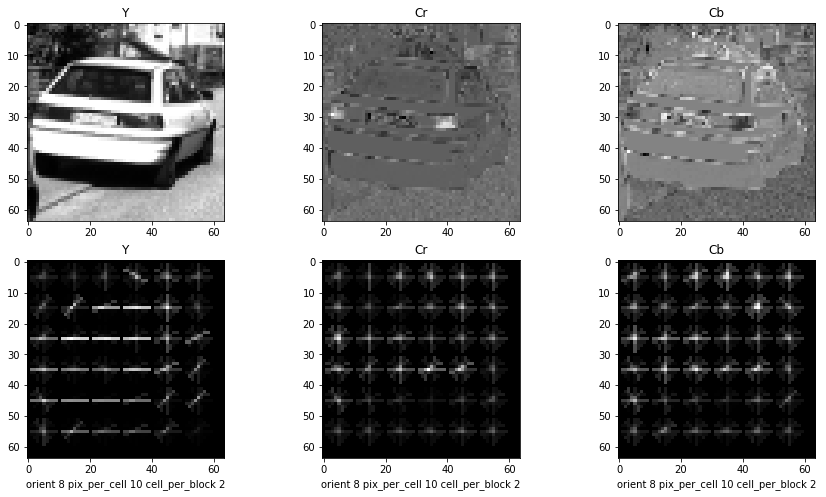

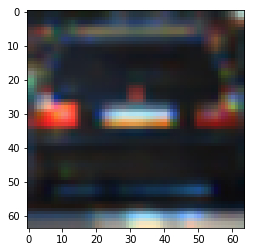

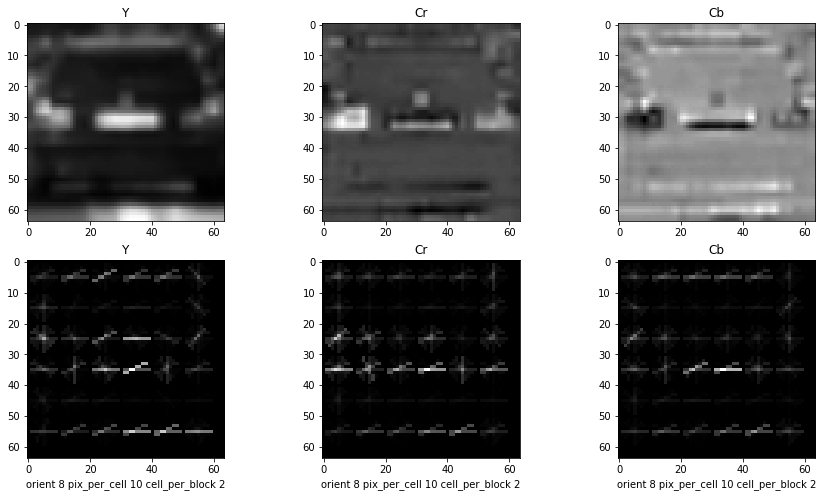

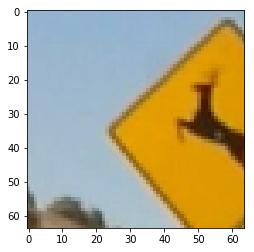

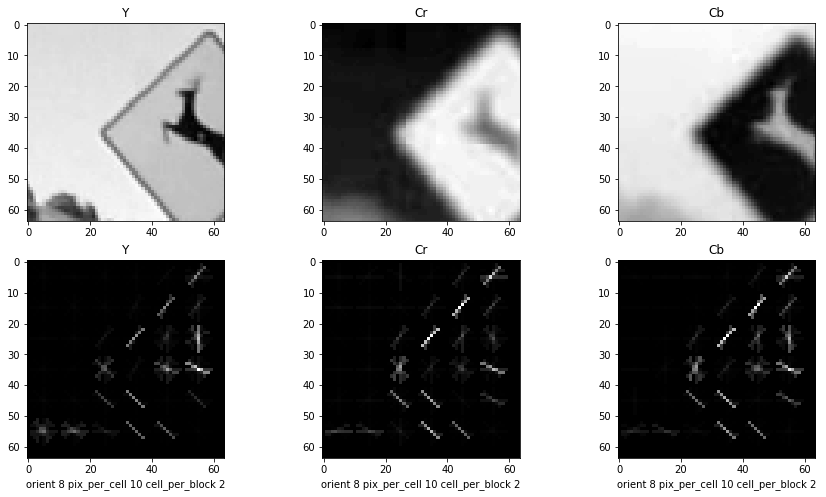

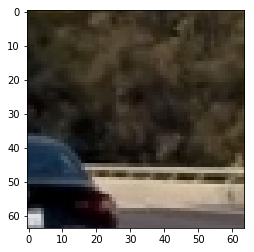

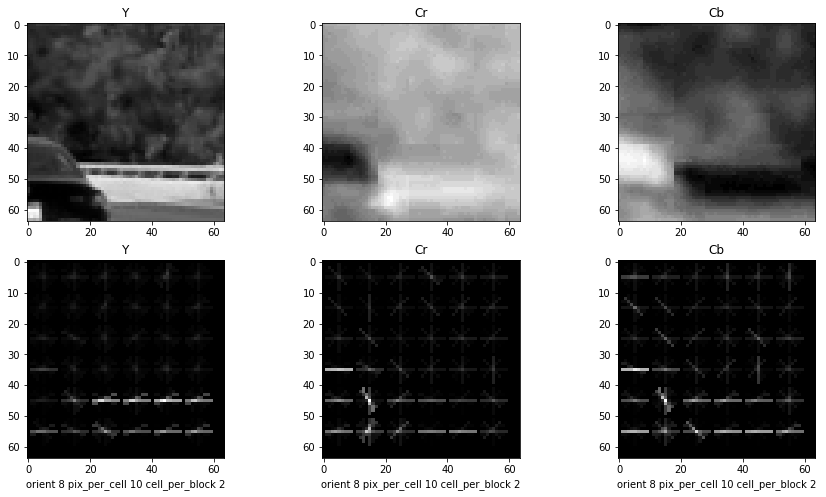

In [55]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

def hog_visualize(image, orient = 8,pix_per_cell = 8,cell_per_block = 2, im_type='Vehicle'):
    # Call our function with vis=True to see an image output
    features_1, hog_image_8 = get_hog_features(image, orient, 
                            8, cell_per_block, 
                            vis=True, feature_vec=True)
    features_2, hog_image_10 = get_hog_features(image, orient, 
                            10, cell_per_block, 
                            vis=True, feature_vec=True)
    features_3, hog_image_12 = get_hog_features(image, orient, 
                            12, cell_per_block, 
                            vis=True, feature_vec=True)

    # Plot the examples
    fig, ax = plt.subplots(1,4,figsize=(15,8))
    ax[0].imshow(image,cmap='gray')
    ax[0].set_title('Example '+im_type+' Image')
    ax[1].imshow(hog_image_8, cmap='gray')
    ax[1].set_title('FeatureVec Length = '+np.str(len(features_1.ravel() )))
    ax[1].set_xlabel('orient '+np.str(orient)+' pix_per_cell 8'+' cell_per_block '+np.str(cell_per_block))
    ax[2].imshow(hog_image_10, cmap='gray')
    ax[2].set_title('FeatureVec Length = '+np.str(len(features_2.ravel() )))
    ax[2].set_xlabel('orient '+np.str(orient)+' pix_per_cell 10'+' cell_per_block '+np.str(cell_per_block))
    ax[3].imshow(hog_image_12, cmap='gray')
    ax[3].set_title('FeatureVec Length = '+np.str(len(features_3.ravel() )))
    ax[3].set_xlabel('orient '+np.str(orient)+' pix_per_cell 12'+' cell_per_block '+np.str(cell_per_block))

    plt.show()

# Visualization
image = cv2.imread(car_images[4500],0)
hog_visualize(image, orient = 10, pix_per_cell = 8, cell_per_block = 2,im_type='Vehicle')
image = cv2.imread(car_images[3500],0)
hog_visualize(image, orient = 10, pix_per_cell = 8, cell_per_block = 2,im_type='Vehicle')
image = cv2.imread(notcar_images[1300],0)
hog_visualize(image, orient = 10, pix_per_cell = 8, cell_per_block = 2,im_type='Non-Vehicle')

image = cv2.imread(car_images[4500],0)
hog_visualize(image, orient = 8, pix_per_cell = 8, cell_per_block = 2,im_type='Vehicle')
image = cv2.imread(car_images[3500],0)
hog_visualize(image, orient = 8, pix_per_cell = 8, cell_per_block = 2,im_type='Vehicle')
image = cv2.imread(notcar_images[1300],0)
hog_visualize(image, orient = 8, pix_per_cell = 8, cell_per_block = 2,im_type='Non-Vehicle')

image = cv2.imread(car_images[4500],0)
hog_visualize(image, orient = 6, pix_per_cell = 8, cell_per_block = 2,im_type='Vehicle')
image = cv2.imread(car_images[3500],0)
hog_visualize(image, orient = 6, pix_per_cell = 8, cell_per_block = 2,im_type='Vehicle')
image = cv2.imread(notcar_images[1300],0)
hog_visualize(image, orient = 6, pix_per_cell = 8, cell_per_block = 2,im_type='Non-Vehicle')

image = cv2.imread(car_images[4500],0)
hog_visualize(image, orient = 6, pix_per_cell = 8, cell_per_block = 4,im_type='Vehicle')
image = cv2.imread(car_images[3500],0)
hog_visualize(image, orient = 6, pix_per_cell = 8, cell_per_block = 4,im_type='Vehicle')
image = cv2.imread(notcar_images[1300],0)
hog_visualize(image, orient = 6, pix_per_cell = 8, cell_per_block = 4,im_type='Non-Vehicle')


def hog_visualize_colorspace(image, orient,pix_per_cell,cell_per_block, c1,c2,c3):
    
    
    # Plot the examples
    fig, ax = plt.subplots(2,3,figsize=(15,8))
    ax = ax.flatten()

    cspace = (c1+c2+c3)
    if  cspace == 'HSV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    elif cspace == 'LUV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
    elif cspace == 'HLS':
        feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    elif cspace == 'YUV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    elif cspace == 'YCrCb':
        feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)

        
    ax[0].imshow(feature_image[:,:,0],cmap='gray')
    ax[0].set_title(c1)
    ax[1].imshow(feature_image[:,:,1],cmap='gray')
    ax[1].set_title(c2)
    ax[2].imshow(feature_image[:,:,2],cmap='gray')
    ax[2].set_title(c3)
        
    features, hog_image = get_hog_features(feature_image[:,:,0],8,10,2,vis=True,feature_vec=False)
    ax[3].imshow(hog_image, cmap='gray')
    ax[3].set_title(c1)
    ax[3].set_xlabel('orient 8 pix_per_cell 10 cell_per_block 2')

    features, hog_image = get_hog_features(feature_image[:,:,1],8,10,2,vis=True,feature_vec=False)
    ax[4].imshow(hog_image, cmap='gray')
    ax[4].set_title(c2)
    ax[4].set_xlabel('orient 8 pix_per_cell 10 cell_per_block 2')
    
    features, hog_image = get_hog_features(feature_image[:,:,2],8,10,2,vis=True,feature_vec=False)
    ax[5].imshow(hog_image, cmap='gray')
    ax[5].set_title(c3)
    ax[5].set_xlabel('orient 8 pix_per_cell 10 cell_per_block 2')

    plt.show()
    
def visualize_colorspace(c1,c2,c3):
    image = cv2.imread(car_images[4500])
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
    hog_visualize_colorspace(image, 8, 10, 2, c1,c2,c3)
    image = cv2.imread(car_images[3500])
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
    hog_visualize_colorspace(image, 8, 10, 2, c1,c2,c3)
    image = cv2.imread(notcar_images[1300])
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
    hog_visualize_colorspace(image, 8, 10, 2, c1,c2,c3)
    image = cv2.imread(notcar_images[13])
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
    hog_visualize_colorspace(image, 8, 10, 2, c1,c2,c3)
    
visualize_colorspace('H','S','V')
visualize_colorspace('L','U','V')
visualize_colorspace('H','L','S')
visualize_colorspace('Y','U','V')
visualize_colorspace('Y','Cr','Cb')

#### Redifined Functions for Training

In [3]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features



# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='BGR', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,spatial_size=(16, 16),
                        hist_bins=32, hist_range=(0, 256),spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'BGR':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        else: feature_image = np.copy(image)  
        # Apply bin_spatial() to get spatial color features
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)   
        # Apply color_hist() to get color histogram features
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
            file_features.append(hist_features)
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        # Append the new feature vector to the features list
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


### SVM Training

In [4]:
colorspace = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8
pix_per_cell = 10
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spacial_size = (8,8)
hist_bins = 16
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

t=time.time()
car_features = extract_features(car_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,spatial_size=spacial_size,
                        hist_bins=hist_bins, hist_range=(0, 256),
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcar_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,spatial_size=spacial_size,
                        hist_bins=hist_bins, hist_range=(0, 256),
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract bin_spatial, color_hist, and HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('colorspace = '+colorspace)
print('spacial_size ='+np.str(spacial_size))
print('hist_bins = '+np.str(hist_bins))
print('hog_channel = ALL') #'+np.str(hog_channel))
print('Feature vector length:', len(X_train[0]))


# # try different kernel and parameters C and gamma

### CODES FROM SCIKIT LEARN 
### CODES FROM SCIKIT LEARN 
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-4],
                     'C': [10]},
                    {'kernel': ['linear'], 'C': [20]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
### CODES FROM SCIKIT LEARN 
### CODES FROM SCIKIT LEARN 


## For Exploring Different Feature Extraction Parameters ##
## For Exploring Different Feature Extraction Parameters ##
# # Use a linear SVC 
# svc = LinearSVC()
# # Check the training time for the SVC
# t=time.time()
# svc.fit(X_train, y_train)
# t2 = time.time()
# print(round(t2-t, 2), 'Seconds to train SVC...')
## For Exploring Different Feature Extraction Parameters ##
## For Exploring Different Feature Extraction Parameters ##


# Check the score of the SVC
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts:     ', clf.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')


94.09 Seconds to extract bin_spatial, color_hist, and HOG features...
Using: 8 orientations 10 pixels per cell and 2 cells per block
colorspace = HSV
spacial_size =(8, 8)
hist_bins = 16
hog_channel = ALL
Feature vector length: 2640
# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'gamma': 0.0001, 'kernel': 'rbf', 'C': 10}

Grid scores on development set:

0.995 (+/-0.002) for {'gamma': 0.0001, 'kernel': 'rbf', 'C': 10}
0.990 (+/-0.003) for {'kernel': 'linear', 'C': 20}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

        0.0       1.00      0.99      1.00      1774
        1.0       0.99      1.00      1.00      1778

avg / total       1.00      1.00      1.00      3552


# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'gamma': 0.0001, 'kernel': 'rbf', 'C': 10}

Gri

### Save Trained Classifier

In [6]:
# Save the Trained Classifier 
from sklearn.externals import joblib
from sklearn.datasets import load_digits
from sklearn.linear_model import SGDClassifier

filename = 'trained_classifier/vehicle_classifier_995.pkl'
joblib.dump(clf, filename)
filename = 'trained_classifier/X_scaler_995.pkl'
joblib.dump(X_scaler, filename)


['trained_classifier/X_scaler_995.pkl']